In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## part I

In [2]:
df_crsp = pd.read_csv("tu3e7tghqndc56ej.csv.gz", na_values=['C'], parse_dates=['date'])

# The output from WRDS returns a mixed of small and large cap column names.
# We can easily convert everything to small caps.
cols = df_crsp.columns
df_crsp.columns = [c.lower() for c in cols]
df_crsp.drop_duplicates(keep='first',inplace=True)
df_crsp.reset_index(inplace=True,drop=True)
df_crsp = df_crsp[df_crsp['exchcd'] == 1.0]
df_crsp['ret'] = pd.to_numeric(df_crsp['ret'], errors='coerce')

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
916,10006,1967-01-31,1.0,22156,43.62500,955.0,0.140523,5748.0,0.085530,0.172104
917,10006,1967-02-28,1.0,22156,41.50000,1067.0,-0.036103,5748.0,0.010945,0.042368
918,10006,1967-03-31,1.0,22156,48.00000,1905.0,0.156627,5748.0,0.043384,0.058244
919,10006,1967-04-28,1.0,22156,50.50000,983.0,0.052083,5748.0,0.041609,0.041928
920,10006,1967-05-31,1.0,22156,49.00000,1001.0,-0.018812,5748.0,-0.039293,-0.008098
...,...,...,...,...,...,...,...,...,...,...
4540064,93427,2023-08-31,1.0,53445,160.77000,100449.0,0.300307,36191.0,-0.020605,-0.052542
4540065,93427,2023-09-29,1.0,53445,166.62000,64970.0,0.036387,36191.0,-0.047390,-0.055443
4540066,93427,2023-10-31,1.0,53445,155.00000,77214.0,-0.069739,36331.0,-0.028867,-0.060887
4540067,93427,2023-11-30,1.0,53445,161.89999,68822.0,0.044516,36331.0,0.092057,0.080251


In [3]:
# 筛选出1926年的数据,这一步是在check有多少上市公司
data_1967 = df_crsp[df_crsp['date'].dt.year == 1967]  
# 根据 permno 去重，统计公司数量
unique_companies = data_1967['permno'].nunique()
unique_companies

1321

In [4]:
df_crsp['prc'] = abs(df_crsp['prc'])#取绝对值

df_crsp

,permno,date,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd
916,10006,1967-01-31,1.0,22156,43.62500,955.0,0.140523,5748.0,0.085530,0.172104
917,10006,1967-02-28,1.0,22156,41.50000,1067.0,-0.036103,5748.0,0.010945,0.042368
918,10006,1967-03-31,1.0,22156,48.00000,1905.0,0.156627,5748.0,0.043384,0.058244
919,10006,1967-04-28,1.0,22156,50.50000,983.0,0.052083,5748.0,0.041609,0.041928
920,10006,1967-05-31,1.0,22156,49.00000,1001.0,-0.018812,5748.0,-0.039293,-0.008098
...,...,...,...,...,...,...,...,...,...,...
4540064,93427,2023-08-31,1.0,53445,160.77000,100449.0,0.300307,36191.0,-0.020605,-0.052542
4540065,93427,2023-09-29,1.0,53445,166.62000,64970.0,0.036387,36191.0,-0.047390,-0.055443
4540066,93427,2023-10-31,1.0,53445,155.00000,77214.0,-0.069739,36331.0,-0.028867,-0.060887
4540067,93427,2023-11-30,1.0,53445,161.89999,68822.0,0.044516,36331.0,0.092057,0.080251


In [5]:
from collections import defaultdict

# 确保 'date' 列是 datetime 格式
df_crsp['date'] = pd.to_datetime(df_crsp['date'])

# 起始年份和截止年份
start_year = 1967
end_year = 2023
start_month = 1

# 初始化变量
date = []
valid_firm_number = []
total_number = []
filter_all_data = defaultdict(list)

# 按年份逐年递增
for year in range(start_year, end_year + 1):
    sum_valid = 0  # 累计连续85个月的次数
    total_tests = 0  # 总的测试次数
    # 计算当前循环的起始时间
    start_date = pd.Timestamp(year=year, month=start_month, day=1)
    end_date = start_date + pd.DateOffset(months=85)  # 85个月的截止时间

    date.append(start_date.date())

    # 筛选在当前时间范围内的数据
    need_data = df_crsp.copy(deep=True)
    need_data.dropna(inplace=True)
    filtered_data = need_data[(need_data['date'] >= start_date)]
    grouped_data = filtered_data.groupby('permno').filter(
        lambda x: (x['date'].iloc[0].year == start_date.year) and (x['date'].iloc[0].month == start_date.month)
    )
    grouped_data = grouped_data.groupby('permno')  # 再次按 permno 分组

    # 遍历每个分组，判断前85个月的连续性
    for idx, group in grouped_data:
        total_tests += 1  # 统计总测试次数

        # 提取当前分组前85个月的数据
        first_85 = group.head(85).copy()
        first_85['year'] = first_85['date'].dt.year
        first_85['month'] = first_85['date'].dt.month
        first_85['month_number'] = (first_85['year'] - first_85['year'].iloc[0]) * 12 + first_85['month']

        # 判断连续性
        first_85['month_diff'] = first_85['month_number'].diff().fillna(1)
        first_85['is_consecutive'] = first_85['month_diff'] == 1

        if first_85['is_consecutive'].all():
            sum_valid += 1
            filter_all_data[start_date.date()].append(idx)

    valid_firm_number.append(sum_valid)
    total_number.append(total_tests)

# 输出结果
for i in range(len(date)):
    print(
        f"起始日期:{date[i]}, 符合要求公司比例: {valid_firm_number[i] / total_number[i]:.2%}, "
        f"符合要求公司总数: {valid_firm_number[i]}, 有效公司总数: {total_number[i]}"
    )

del need_data


起始日期:1967-01-01, 符合要求公司比例: 98.18%, 符合要求公司总数: 1241, 有效公司总数: 1264
起始日期:1968-01-01, 符合要求公司比例: 98.14%, 符合要求公司总数: 1215, 有效公司总数: 1238
起始日期:1969-01-01, 符合要求公司比例: 97.28%, 符合要求公司总数: 1214, 有效公司总数: 1248
起始日期:1970-01-01, 符合要求公司比例: 94.65%, 符合要求公司总数: 1221, 有效公司总数: 1290
起始日期:1971-01-01, 符合要求公司比例: 94.06%, 符合要求公司总数: 1250, 有效公司总数: 1329
起始日期:1972-01-01, 符合要求公司比例: 93.42%, 符合要求公司总数: 1307, 有效公司总数: 1399
起始日期:1973-01-01, 符合要求公司比例: 93.05%, 符合要求公司总数: 1380, 有效公司总数: 1483
起始日期:1974-01-01, 符合要求公司比例: 92.92%, 符合要求公司总数: 1430, 有效公司总数: 1539
起始日期:1975-01-01, 符合要求公司比例: 92.86%, 符合要求公司总数: 1431, 有效公司总数: 1541
起始日期:1976-01-01, 符合要求公司比例: 92.89%, 符合要求公司总数: 1424, 有效公司总数: 1533
起始日期:1977-01-01, 符合要求公司比例: 96.19%, 符合要求公司总数: 1490, 有效公司总数: 1549
起始日期:1978-01-01, 符合要求公司比例: 96.89%, 符合要求公司总数: 1496, 有效公司总数: 1544
起始日期:1979-01-01, 符合要求公司比例: 97.74%, 符合要求公司总数: 1511, 有效公司总数: 1546
起始日期:1980-01-01, 符合要求公司比例: 97.85%, 符合要求公司总数: 1499, 有效公司总数: 1532
起始日期:1981-01-01, 符合要求公司比例: 98.24%, 符合要求公司总数: 1509, 有效公司总数: 1536
起始日期:1982-01-01, 符合要求公司比例: 98.63%, 符合要求公

In [6]:
valid_firm_number

[1241,
 1215,
 1214,
 1221,
 1250,
 1307,
 1380,
 1430,
 1431,
 1424,
 1490,
 1496,
 1511,
 1499,
 1509,
 1508,
 1481,
 1510,
 1502,
 1492,
 1518,
 1605,
 1620,
 1654,
 1713,
 1824,
 2040,
 2300,
 2476,
 2557,
 2739,
 2827,
 2841,
 2760,
 2569,
 2511,
 2512,
 2512,
 2578,
 2622,
 2656,
 2485,
 2402,
 2391,
 2427,
 2442,
 2481,
 2543,
 2606,
 2571,
 2482,
 2465,
 2446,
 2397,
 2422,
 2626,
 2520]

In [7]:
print(total_number)

[1264, 1238, 1248, 1290, 1329, 1399, 1483, 1539, 1541, 1533, 1549, 1544, 1546, 1532, 1536, 1529, 1493, 1517, 1510, 1500, 1527, 1615, 1633, 1667, 1727, 1837, 2056, 2311, 2488, 2569, 2754, 2844, 2858, 2776, 2589, 2532, 2538, 2536, 2604, 2649, 2679, 2505, 2417, 2400, 2436, 2454, 2493, 2555, 2619, 2584, 2492, 2475, 2453, 2403, 2426, 2628, 2521]


In [8]:
#可以通过如下方式筛选出不同起始点所对应的满足连续85个月都有数值的要求的股票，数字为代码 permno
#filter_all_data[pd.to_datetime('1934-01-01').date()]

In [9]:
df_crsp[df_crsp['ret'] > 1].shape[0]

735

In [10]:
def filter_consecutive_data(date, consecutive_months=84):
    start_date = date - pd.DateOffset(months=consecutive_months)
    return filter_all_data[pd.to_datetime(start_date).date()]

In [11]:
len(filter_consecutive_data(pd.to_datetime('1974-01-01'), consecutive_months=84))

1241

In [12]:
df_crsp['lret'] = np.log(1 + df_crsp['ret'])
df_crsp['lvwretd'] = np.log(1 + df_crsp['vwretd'])
df_crsp['lewretd'] = np.log(1 + df_crsp['ewretd'])

# Compute the market cap
df_crsp['size'] = df_crsp['shrout'] * df_crsp['prc']

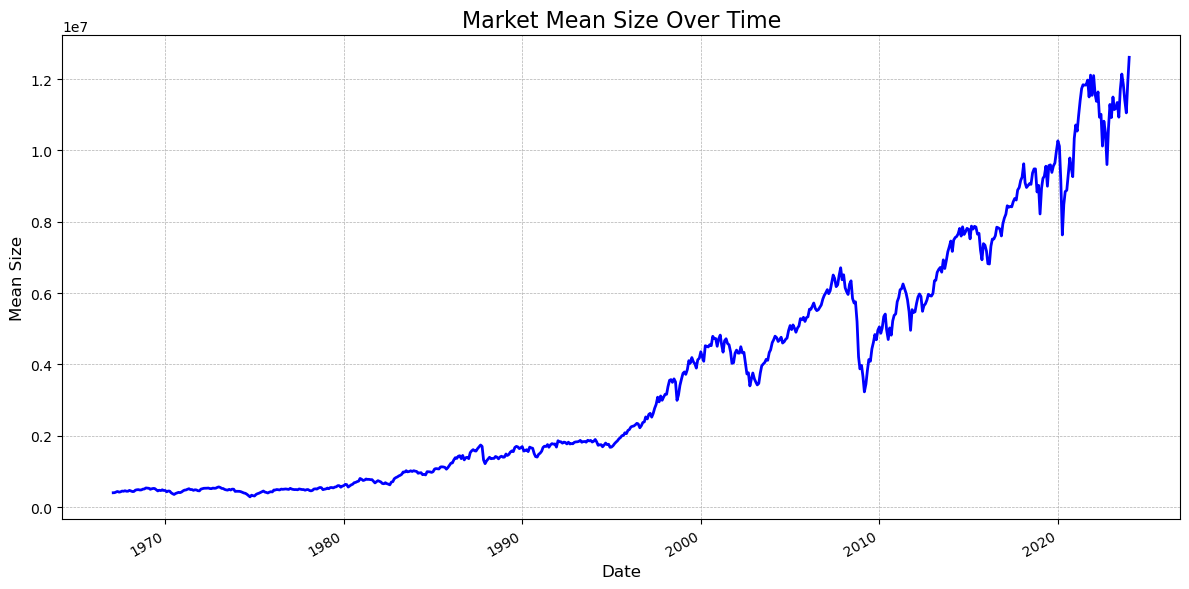

In [13]:
# Calculate and plot the mean size
plt.subplots(figsize=(12, 6))

df_crsp.groupby(['date'])['size'].mean().plot(color='blue', linewidth=2)
# Enhance the plot with grid, intercept, title, and labels
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.title('Market Mean Size Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Mean Size', fontsize=12)

# Show plot with enhancements
plt.tight_layout()
plt.show()

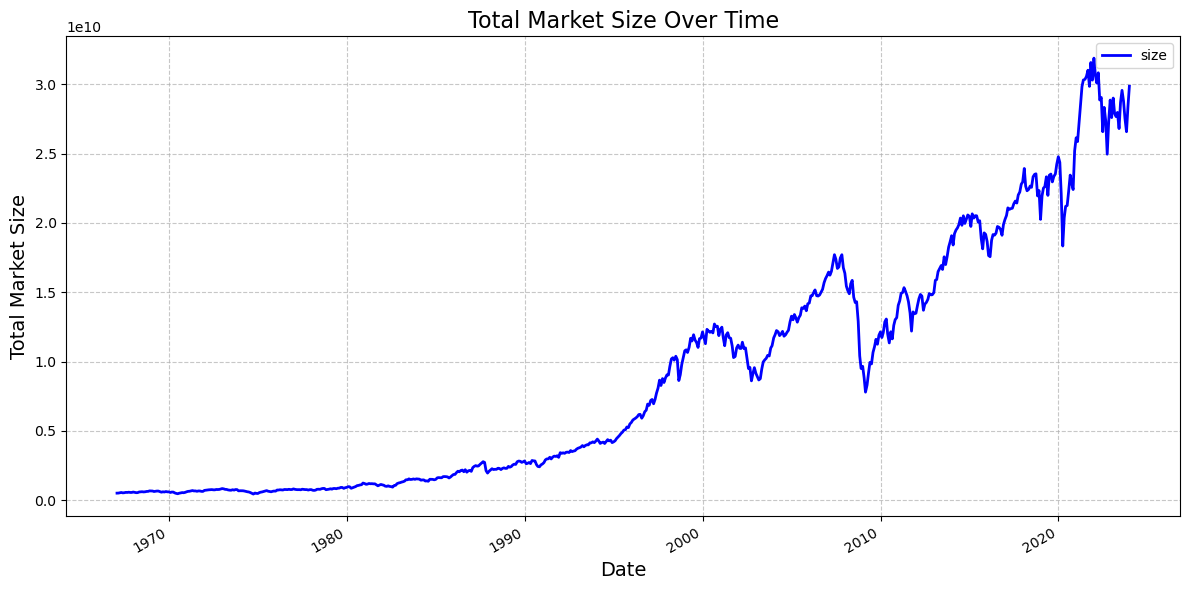

In [14]:
# Plotting total market size over time
fig, ax = plt.subplots(figsize=(12, 6))
df_crsp.groupby(['date'])['size'].sum().plot(color='blue', linewidth=2)

# Enhancing the plot
ax.set_title('Total Market Size Over Time', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Total Market Size', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


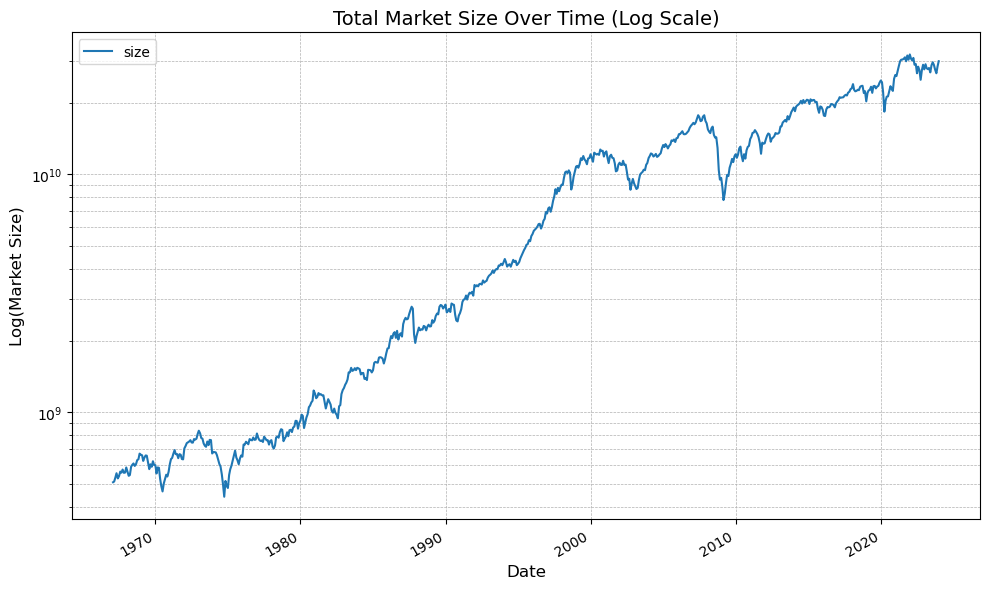

In [15]:

# Plot total market size over time in log scale
fig, ax = plt.subplots(figsize=(10, 6))
df_crsp.groupby(['date'])['size'].sum().plot(logy=True, ax=ax)

# Adding a vertical line for Black Monday

# Enhancing the plot
ax.set_title("Total Market Size Over Time (Log Scale)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Log(Market Size)", fontsize=12)
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Part II

In [16]:
df_crsp = df_crsp.set_index('date')
df_crsp = df_crsp.sort_index()

In [17]:
df_crsp

,permno,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,,
1967-01-31,10006,1.0,22156,43.625,955.0,0.140523,5748.0,0.085530,0.172104,0.131487,0.082068,0.15880,250756.50
1967-01-31,28564,1.0,20371,35.000,1799.0,0.111111,3204.0,0.085530,0.172104,0.105360,0.082068,0.15880,112140.00
1967-01-31,28556,1.0,23551,20.750,1547.0,0.169014,5619.0,0.085530,0.172104,0.156161,0.082068,0.15880,116594.25
1967-01-31,28548,1.0,23550,36.000,1532.0,0.035971,3360.0,0.085530,0.172104,0.035339,0.082068,0.15880,120960.00
1967-01-31,28513,1.0,23547,57.750,594.0,0.094787,4184.0,0.085530,0.172104,0.090560,0.082068,0.15880,241626.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,79895,1.0,30025,5.440,206872.0,-0.026834,12416.0,0.053468,0.083840,-0.027201,0.052088,0.08051,67543.04
2023-12-29,17378,1.0,56311,3.760,3093.0,0.030137,66789.0,0.053468,0.083840,0.029692,0.052088,0.08051,251126.64
2023-12-29,14185,1.0,54577,19.540,40029.0,0.101466,17197.0,0.053468,0.083840,0.096642,0.052088,0.08051,336029.38


In [18]:
# 计算36个月formation period，构建top bottom portfolio

def compute_performance_portfolios(hold_date, data, formation_period=36, use_deciles=True, n_stocks=35, benchmark='ewretd'):
    """
    Computes the top and bottom portfolios based on stock performance in the formation period prior to the given date.
    
    Parameters:
        hold_date (datetime): The portfolio hold date.
        data (DataFrame): DataFrame containing stock data with required columns like 'log_return', 'log_market_return', etc.
        formation_period (int): The number of months in the formation period.
        use_deciles (bool): Whether to use decile-based grouping or a fixed number of stocks.
        n_stocks (int): The number of top/bottom stocks if not using deciles.
        benchmark (str): The benchmark column name to compute excess returns.
        
    Returns:
        bottom_portfolio (DataFrame): DataFrame containing bottom portfolio stocks and their excess returns.
        top_portfolio (DataFrame): DataFrame containing top portfolio stocks and their excess returns.
    """
    valid_list = filter_consecutive_data(hold_date, consecutive_months=84)
    # Define the beginning date of the formation period
    start_date = hold_date - pd.DateOffset(months=formation_period)
    
    # Filter data for the formation period
    formation_data = data[
        (data.index >= start_date) & (data.index <= hold_date.to_pydatetime()) & (data['permno'].isin(valid_list))
        ].copy()
    # Group by stock_id and compute total log returns over the formation period
    stock_returns = formation_data.groupby('permno')[['lret', 'lvwretd', 'lewretd']].sum()
    # Compute excess returns based on the chosen benchmark
    stock_returns['lexret'] = stock_returns['lret'] - stock_returns['l' + benchmark]

    # Compute deciles and rankings for excess returns

    stock_returns['decile'] = pd.qcut(stock_returns['lexret'], 9, labels=False)  # (0 = worst, 9 = best)
    stock_returns['rank_asc'] = stock_returns['lexret'].rank()  # (1 = worst return)
    stock_returns['rank_desc'] = stock_returns['lexret'].rank(ascending=False)  # (1 = best return)

    # Select top and bottom portfolios
    if use_deciles:
        top_portfolio = stock_returns[stock_returns['decile'] == 8].reset_index()[['permno', 'lexret']]
        bottom_portfolio = stock_returns[stock_returns['decile'] == 0].reset_index()[['permno', 'lexret']]
    else:
        top_portfolio = stock_returns[stock_returns['rank_desc'] <= n_stocks].reset_index()[['permno', 'lexret']]
        bottom_portfolio = stock_returns[stock_returns['rank_asc'] <= n_stocks].reset_index()[['permno', 'lexret']]

    return bottom_portfolio, top_portfolio

In [19]:
#权重部分待修改
def calculate_portfolio_returns_modified(date, portfolio, price_data, benchmark_type, weight_type, holding_months):
    
    end_date = date + pd.offsets.MonthBegin(holding_months)
    period_data = price_data.loc[(price_data.index >= date) & (price_data.index <= end_date)].copy()
    
    stock_data = pd.merge(period_data.reset_index(), portfolio.copy(), on=['permno'])
    date_stock_pairs = [(d, p) for d in stock_data['date'].unique() 
                               for p in portfolio['permno'].unique()]
    complete_pairs = pd.DataFrame(date_stock_pairs, columns=['date', 'permno'])
    stock_data = pd.merge(stock_data, complete_pairs, how='outer', on=['permno', 'date'])

    # Handle missing returns
    return_columns = ['ret', 'vwretd', 'ewretd', 'lvwretd', 'lewretd', 'lret', 'lexret']

    def drop_rows_after_first_nan(data):
    # 找到每组中首次出现 NaN 的索引
        def find_first_nan(group):
            nan_index = group['prc'].isna().idxmax() if group['prc'].isna().any() else None
            return nan_index

        # 按照 permno 分组
        grouped = data.groupby('permno')

        # 找到每组中首次出现 NaN 的索引
        nan_indices = grouped.apply(find_first_nan)

        # 遍历每组，根据首次 NaN 的索引删除后续行
        def remove_after_nan(group, nan_index):
            if nan_index is not None:
                group = group.loc[:nan_index - 1]
            return group

        def safe_remove_after_nan(group):
            # 检查 nan_indices 是否包含当前组名
            if group.name in nan_indices:
                nan_index = nan_indices[group.name]
            else:
                nan_index = None
            return remove_after_nan(group, nan_index)

        cleaned_data = grouped.apply(safe_remove_after_nan)
        # 去掉多余的分组索引
        cleaned_data = cleaned_data.reset_index(drop=True)

        return cleaned_data

    # 根据nan进行过组合筛选
    new_stock_data = drop_rows_after_first_nan(stock_data)

    #def portfoliio_reconstruct(stock_data, date):
    #    stock_data['log_cum_ret'] = stock_data.groupby('permno')['prc']
    #    stock_data['log_cum_benchmark'] = price_data.groupby('permno')['l' + benchmark_type].cumsum()
    #    return stock_data
        
    #权重这里有点奇怪，可能需要修改
    def calculate_weights(portfolio, price_data, date):
        weights = portfolio.copy()
        weights['ew'] = 1.0 / len(portfolio)
        weights['date'] = date
        market_cap = pd.merge_asof(weights, 
                                 price_data[['permno', 'size']],
                                 by='permno',
                                 left_on='date',
                                 right_index=True)
        
        market_cap['vw'] = market_cap['size'] / market_cap['size'].sum()
        return market_cap[['permno', 'ew', 'vw']]
    
    weights = calculate_weights(portfolio, price_data, date)
    new_stock_data = pd.merge(new_stock_data, weights, on='permno')

    def calculate_AR_CAR(stock_data,benchmark):
        #first calcultae AR
        stock_data[f'weighted_ret'] = stock_data[weight_type] * stock_data['ret']
        stock_data[f'weighted_benchmark'] = stock_data[weight_type] * stock_data[benchmark]
    
        portfolio_returns = stock_data.groupby('date')[[f'weighted_ret', f'weighted_benchmark']].sum()
        
        
        portfolio_returns = portfolio_returns.reset_index()
        portfolio_returns['months'] = range(1, len(portfolio_returns) + 1)
        portfolio_returns['AR'] = (portfolio_returns[f'weighted_ret'] - 
                                            portfolio_returns[f'weighted_benchmark'])
        #then use AR to calculate CAR
        portfolio_returns['CAR'] = portfolio_returns['AR'].cumsum()

        return portfolio_returns[['months', 'AR','CAR']]
        
    return calculate_AR_CAR(new_stock_data,benchmark_type)

def compute_portfolio_performance_modified(start_dates, portfolios, price_data, benchmark_type, weight_type,holding_months):
    bottom_returns = []
    top_returns = []
    
    for date in start_dates:
        bottom_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][0],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
        top_returns.append(
                calculate_portfolio_returns_modified(
                date,
                portfolios[date][1],
                price_data,
                benchmark_type, 
                weight_type, 
                holding_months
            )
        )
    
    bottom_returns = pd.concat(bottom_returns, ignore_index=True)
    top_returns = pd.concat(top_returns, ignore_index=True)
    
    # Add starting point (0,0) for CAR
    zero_point = pd.DataFrame({'months': [0], 'AR': [0], 'CAR': [0]})
    
    # Group by 'months' and calculate mean for AR and CAR directly
    bottom_mean = bottom_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    top_mean = top_returns.groupby('months')[['AR', 'CAR']].mean().reset_index()
    
    # Combine with zero point for final output
    bottom_final = pd.concat([zero_point, bottom_mean], ignore_index=True)
    top_final = pd.concat([zero_point, top_mean], ignore_index=True)
    
    return bottom_final, top_final

In [20]:
#新的画图代码
def draw_CAR_pictures_modified(bottom_returns,top_returns,weight):
    plt.figure(figsize=(8, 6))
    plt.plot(bottom_returns['months'], bottom_returns['CAR'],
            label='Loser Portfolio',
            color='black',
            linestyle='-',
            marker='o',
            markersize=4)

    plt.plot(top_returns['months'], top_returns['CAR'],
            label='Winner Portfolio',
            color='black',
            linestyle='--',
            marker='x',
            markersize=4)

    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)

    plt.title(f'Cumulative Average Residuals for Winner and Loser Portfolios - {weight}', fontsize=12)
    plt.xlabel('MONTHS AFTER PORTFOLIO FORMATION', fontsize=10)
    plt.ylabel('CAR', fontsize=10)

    plt.xticks(fontsize=8)
    plt.yticks(np.arange(-0.1, 0.3, 0.05))

    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

------------

In [21]:
use_deciles = True
n_stocks = 35

In [22]:
form_period_3year = 36
hold_period_3year = 36
start_date_3year = '1974-01-01'
end_date_3year = '2019-01-01'
benchmark = 'ewretd'
period_start_dates_3year = pd.date_range(start=start_date_3year, end=end_date_3year, freq=str(int(form_period_3year)) + 'MS')
period_start_dates_3year

DatetimeIndex(['1974-01-01', '1977-01-01', '1980-01-01', '1983-01-01',
               '1986-01-01', '1989-01-01', '1992-01-01', '1995-01-01',
               '1998-01-01', '2001-01-01', '2004-01-01', '2007-01-01',
               '2010-01-01', '2013-01-01', '2016-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='36MS')

In [23]:
form_period_5year = 60
hold_period_5year = 60
n_stocks_5year = 50
start_date_5year = '1974-01-01'
end_date_5year = '2020-01-01'
benchmark = 'ewretd'
period_start_dates_5year = pd.date_range(start=start_date_5year, end=end_date_5year, freq=str(int(form_period_5year)) + 'MS')
period_start_dates_5year

DatetimeIndex(['1974-01-01', '1979-01-01', '1984-01-01', '1989-01-01',
               '1994-01-01', '1999-01-01', '2004-01-01', '2009-01-01',
               '2014-01-01', '2019-01-01'],
              dtype='datetime64[ns]', freq='60MS')

In [24]:
form_period_2year = 24
hold_period_2year = 24
start_date_2year = '1974-01-01'
end_date_2year = '2020-01-01'
benchmark = 'ewretd'
period_start_dates_2year = pd.date_range(start=start_date_2year, end=end_date_2year, freq=str(int(form_period_2year)) + 'MS')
period_start_dates_2year

DatetimeIndex(['1974-01-01', '1976-01-01', '1978-01-01', '1980-01-01',
               '1982-01-01', '1984-01-01', '1986-01-01', '1988-01-01',
               '1990-01-01', '1992-01-01', '1994-01-01', '1996-01-01',
               '1998-01-01', '2000-01-01', '2002-01-01', '2004-01-01',
               '2006-01-01', '2008-01-01', '2010-01-01', '2012-01-01',
               '2014-01-01', '2016-01-01', '2018-01-01', '2020-01-01'],
              dtype='datetime64[ns]', freq='24MS')

In [25]:
start_date_2year_2 = '1975-01-01'
end_date_2year_2 = '2021-01-01'
benchmark = 'ewretd'
period_start_dates_2year_2 = pd.date_range(start=start_date_2year_2, end=end_date_2year_2, freq=str(int(form_period_2year)) + 'MS')
period_start_dates_2year_2

DatetimeIndex(['1975-01-01', '1977-01-01', '1979-01-01', '1981-01-01',
               '1983-01-01', '1985-01-01', '1987-01-01', '1989-01-01',
               '1991-01-01', '1993-01-01', '1995-01-01', '1997-01-01',
               '1999-01-01', '2001-01-01', '2003-01-01', '2005-01-01',
               '2007-01-01', '2009-01-01', '2011-01-01', '2013-01-01',
               '2015-01-01', '2017-01-01', '2019-01-01', '2021-01-01'],
              dtype='datetime64[ns]', freq='24MS')

In [26]:
form_period_1year = 12
hold_period_1year = 24
start_date_1year = '1974-01-01'
end_date_1year = '2022-01-01'
benchmark = 'ewretd'
period_start_dates_1year = pd.date_range(start=start_date_1year, end=end_date_1year, freq=str(int(form_period_1year)) + 'MS')
period_start_dates_1year

DatetimeIndex(['1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
               '1982-01-01', '1983-01-01', '1984-01-01', '1985-01-01',
               '1986-01-01', '1987-01-01', '1988-01-01', '1989-01-01',
               '1990-01-01', '1991-01-01', '1992-01-01', '1993-01-01',
               '1994-01-01', '1995-01-01', '1996-01-01', '1997-01-01',
               '1998-01-01', '1999-01-01', '2000-01-01', '2001-01-01',
               '2002-01-01', '2003-01-01', '2004-01-01', '2005-01-01',
               '2006-01-01', '2007-01-01', '2008-01-01', '2009-01-01',
               '2010-01-01', '2011-01-01', '2012-01-01', '2013-01-01',
               '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01',
               '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01',
               '2022-01-01'],
              dtype='datetime64[ns]', freq='12MS')

In [27]:
portfolios_thirtyfive_3year = {}
for date in period_start_dates_3year:
    portfolios_thirtyfive_3year[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')

In [28]:
portfolios_thirtyfive_3year = {}
portfolios_fifty_5year = {}
portfolios_thirtyfive_2year = {}
portfolios_thirtyfive_2year_2 = {}
portfolios_ten_decile_2year = {}
portfolios_ten_decile_2year_2 = {}
portfolios_thirtyfive_1year = {}
portfolios_thirtyfive_3year_w = {}
portfolios_fifty_5year_w = {}
portfolios_thirtyfive_2year_w = {}
portfolios_thirtyfive_2year_2_w = {}
portfolios_ten_decile_2year_w = {}
portfolios_ten_decile_2year_2_w = {}
portfolios_thirtyfive_1year_w = {}

for date in period_start_dates_3year:
    portfolios_thirtyfive_3year[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='ewretd')
    portfolios_thirtyfive_3year_w[date] = compute_performance_portfolios(date, df_crsp, use_deciles=False, benchmark='vwretd')

for date in period_start_dates_5year:
    portfolios_fifty_5year[date] = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='ewretd')
    portfolios_fifty_5year_w[date] = compute_performance_portfolios(date, df_crsp,formation_period=50, use_deciles=False, n_stocks=n_stocks_5year, benchmark='vwretd')

for date in period_start_dates_2year:
    portfolios_thirtyfive_2year[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='ewretd')
    portfolios_ten_decile_2year[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='ewretd')
    portfolios_thirtyfive_2year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')
    portfolios_ten_decile_2year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')
for date in period_start_dates_2year_2:
    portfolios_thirtyfive_2year_2[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='ewretd')
    portfolios_ten_decile_2year_2[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='ewretd')
    portfolios_thirtyfive_2year_2_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=False, benchmark='vwretd')
    portfolios_ten_decile_2year_2_w[date] = compute_performance_portfolios(date, df_crsp, formation_period= 24,use_deciles=True, benchmark='vwretd')
for date in period_start_dates_1year:
    portfolios_thirtyfive_1year[date] = compute_performance_portfolios(date, df_crsp, formation_period=12,use_deciles=False, benchmark='ewretd')
    portfolios_thirtyfive_1year_w[date] = compute_performance_portfolios(date, df_crsp, formation_period=12,use_deciles=False, benchmark='vwretd')




In [29]:
calculate_portfolio_returns_modified(
                period_start_dates_3year[2],
                portfolios_thirtyfive_3year[period_start_dates_3year[2]][0],
                df_crsp,
                'vwretd','vw',36)

,months,AR,CAR
0,1,-0.060371,-0.060371
1,2,-0.050616,-0.110987
2,3,0.044359,-0.066627
3,4,0.010463,-0.056164
4,5,-0.005536,-0.061700
5,6,-0.033097,-0.094797
6,7,0.058707,-0.036090
7,8,-0.045795,-0.081885
8,9,-0.066788,-0.148673
9,10,-0.048193,-0.196866


In [30]:
calculate_portfolio_returns_modified(
                period_start_dates_3year[5],
                portfolios_thirtyfive_3year[period_start_dates_3year[5]][0],
                df_crsp,
                'vwretd','vw',36)

,months,AR,CAR
0,1,-0.125507,-0.125507
1,2,0.032071,-0.093436
2,3,-0.028436,-0.121872
3,4,-0.037903,-0.159775
4,5,-0.037188,-0.196964
5,6,-0.177193,-0.374157
6,7,-0.165269,-0.539425
7,8,-0.080149,-0.619574
8,9,-0.106557,-0.726131
9,10,-0.120737,-0.846868


In [31]:
df_crsp

,permno,exchcd,permco,prc,vol,ret,shrout,vwretd,ewretd,lret,lvwretd,lewretd,size
date,,,,,,,,,,,,,
1967-01-31,10006,1.0,22156,43.625,955.0,0.140523,5748.0,0.085530,0.172104,0.131487,0.082068,0.15880,250756.50
1967-01-31,28564,1.0,20371,35.000,1799.0,0.111111,3204.0,0.085530,0.172104,0.105360,0.082068,0.15880,112140.00
1967-01-31,28556,1.0,23551,20.750,1547.0,0.169014,5619.0,0.085530,0.172104,0.156161,0.082068,0.15880,116594.25
1967-01-31,28548,1.0,23550,36.000,1532.0,0.035971,3360.0,0.085530,0.172104,0.035339,0.082068,0.15880,120960.00
1967-01-31,28513,1.0,23547,57.750,594.0,0.094787,4184.0,0.085530,0.172104,0.090560,0.082068,0.15880,241626.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,79895,1.0,30025,5.440,206872.0,-0.026834,12416.0,0.053468,0.083840,-0.027201,0.052088,0.08051,67543.04
2023-12-29,17378,1.0,56311,3.760,3093.0,0.030137,66789.0,0.053468,0.083840,0.029692,0.052088,0.08051,251126.64
2023-12-29,14185,1.0,54577,19.540,40029.0,0.101466,17197.0,0.053468,0.083840,0.096642,0.052088,0.08051,336029.38


In [32]:
bottom_returns_3year_w, top_returns_3year_w = compute_portfolio_performance_modified(period_start_dates_3year, portfolios_thirtyfive_3year_w, df_crsp,'vwretd','vw',36)
bottom_returns_3year, top_returns_3year = compute_portfolio_performance_modified(period_start_dates_3year, portfolios_thirtyfive_3year, df_crsp,'ewretd','ew',36)
bottom_returns_5year_w, top_returns_5year_w = compute_portfolio_performance_modified(period_start_dates_5year, portfolios_fifty_5year_w, df_crsp,'vwretd','vw',60)
bottom_returns_5year, top_returns_5year = compute_portfolio_performance_modified(period_start_dates_5year, portfolios_fifty_5year, df_crsp,'ewretd','ew',60)
bottom_returns_2year_w, top_returns_2year_w = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_thirtyfive_2year_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year, top_returns_2year = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_thirtyfive_2year, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_2, top_returns_2year_w_2 = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_thirtyfive_2year_2_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_2, top_returns_2year_2 = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_thirtyfive_2year_2, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_decile, top_returns_2year_w_decile = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_ten_decile_2year_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_decile, top_returns_2year_decile = compute_portfolio_performance_modified(period_start_dates_2year, portfolios_ten_decile_2year, df_crsp,'ewretd','ew',24)
bottom_returns_2year_w_2_decile, top_returns_2year_w_2_decile = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_ten_decile_2year_2_w, df_crsp,'vwretd','vw',24)
bottom_returns_2year_2_decile, top_returns_2year_2_decile = compute_portfolio_performance_modified(period_start_dates_2year_2, portfolios_ten_decile_2year_2, df_crsp,'ewretd','ew',24)
bottom_returns_1year_w, top_returns_1year_w = compute_portfolio_performance_modified(period_start_dates_1year, portfolios_thirtyfive_1year_w, df_crsp,'vwretd','vw',24)
bottom_returns_1year, top_returns_1year = compute_portfolio_performance_modified(period_start_dates_1year, portfolios_thirtyfive_1year, df_crsp,'ewretd','ew',24)

In [33]:
bottom_returns_3year

,months,AR,CAR
0,0,0.000000,0.000000
1,1,0.082865,0.082865
2,2,0.009591,0.092456
3,3,0.012142,0.104599
4,4,0.013053,0.117651
5,5,-0.015625,0.102026
6,6,-0.014943,0.087083
7,7,-0.006725,0.080358
8,8,-0.003282,0.077075
9,9,-0.001559,0.075517


In [34]:
weighted_bottom = [bottom_returns_3year_w,bottom_returns_5year_w,bottom_returns_2year_w,bottom_returns_2year_w_2,bottom_returns_2year_w_decile,bottom_returns_2year_w_2_decile,bottom_returns_1year_w]
weighted_top = [top_returns_3year_w,top_returns_5year_w,top_returns_2year_w,top_returns_2year_w_2,top_returns_2year_w_decile,top_returns_2year_w_2_decile,top_returns_1year_w]
bottom = [bottom_returns_3year,bottom_returns_5year,bottom_returns_2year,bottom_returns_2year_2,bottom_returns_2year_decile,bottom_returns_2year_2_decile,bottom_returns_1year]
top = [top_returns_3year,top_returns_5year,top_returns_2year,top_returns_2year_2,top_returns_2year_decile,top_returns_2year_2_decile,top_returns_1year_w]
period_start_dates = [period_start_dates_3year,period_start_dates_5year,period_start_dates_2year,period_start_dates_2year_2,period_start_dates_2year,period_start_dates_2year_2,period_start_dates_1year]
portfolios_w = [portfolios_thirtyfive_3year_w,portfolios_fifty_5year_w,portfolios_thirtyfive_2year_w,portfolios_thirtyfive_2year_2_w,portfolios_ten_decile_2year_w,portfolios_ten_decile_2year_2_w,portfolios_thirtyfive_1year_w]
portfolios = [portfolios_thirtyfive_3year,portfolios_fifty_5year,portfolios_thirtyfive_2year,portfolios_thirtyfive_2year_2,portfolios_ten_decile_2year,portfolios_ten_decile_2year_2,portfolios_thirtyfive_1year]
holding_month = [36,60,24,24,24,24,24]

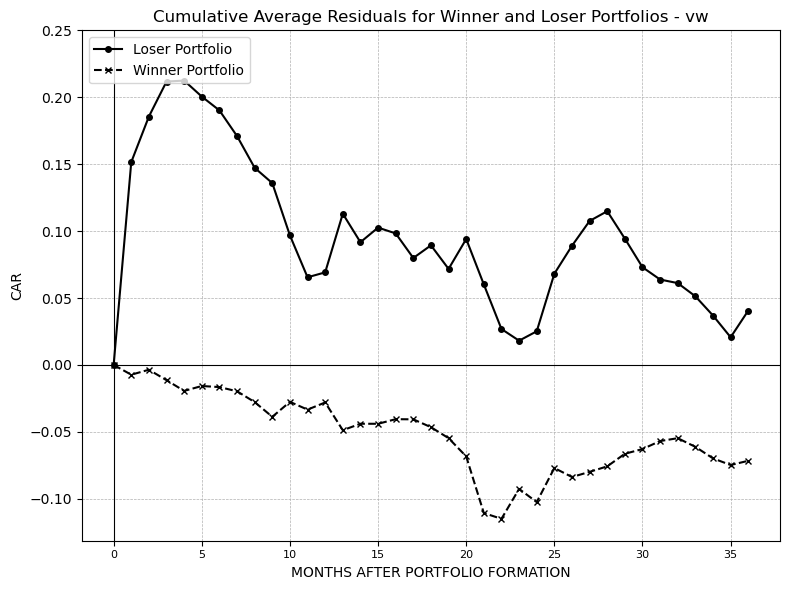

In [35]:
draw_CAR_pictures_modified(bottom_returns_3year_w,top_returns_3year_w,'vw')

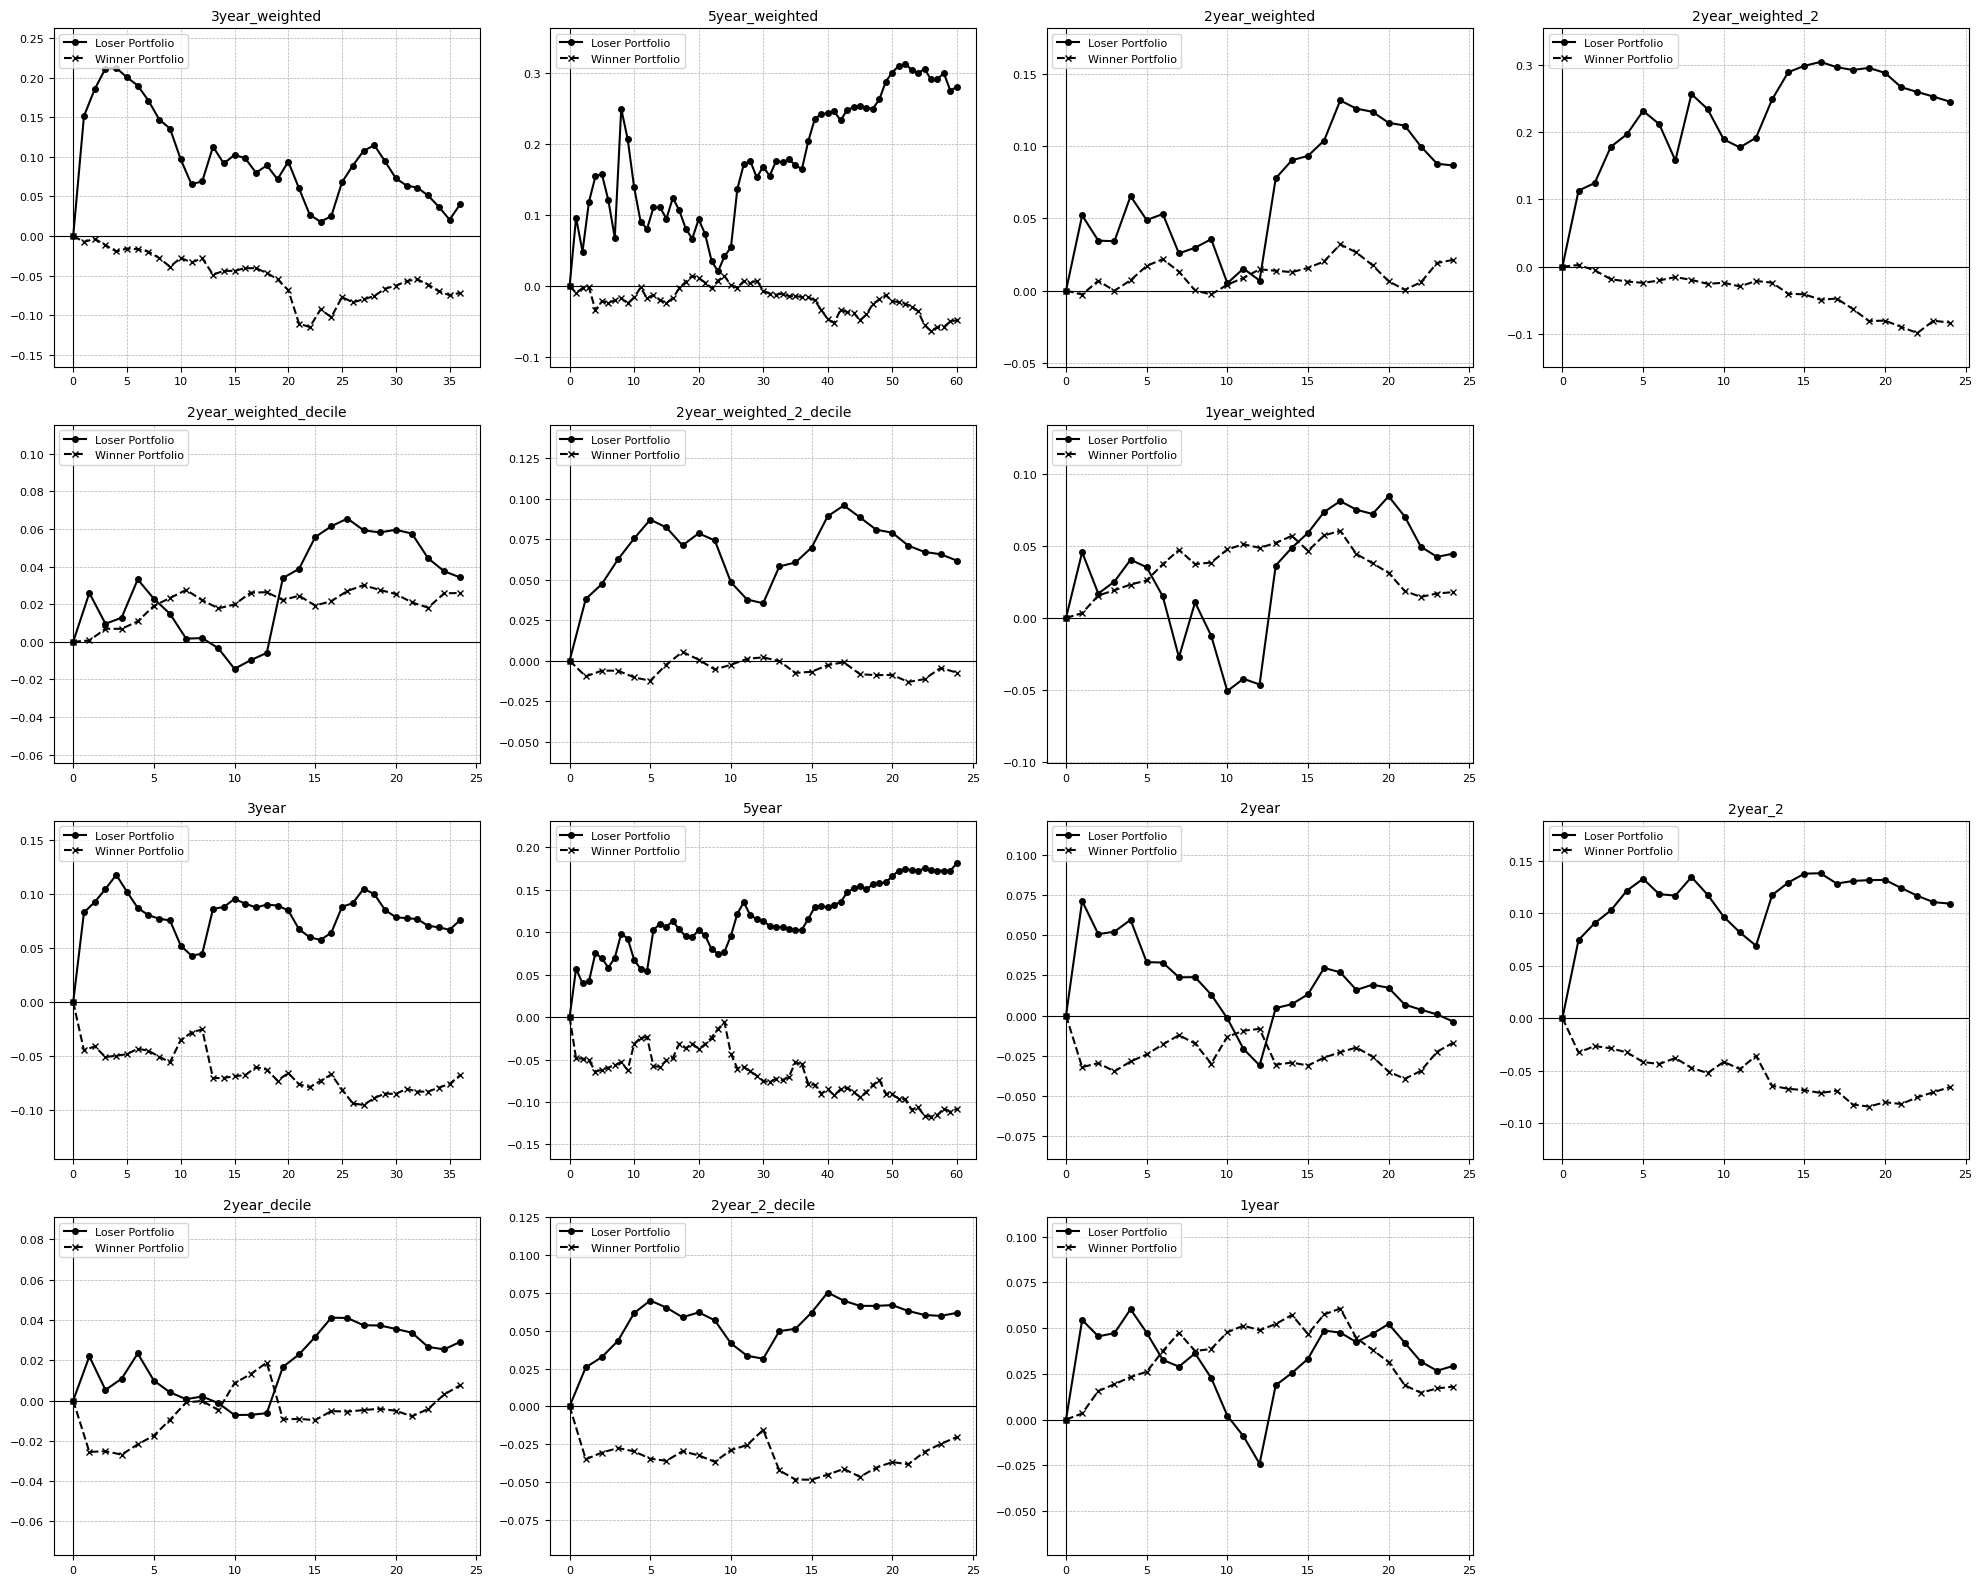

In [36]:
# 将所有 bottom 和 top 合并为 pairs
all_bottom = weighted_bottom + bottom
all_top = weighted_top + top
labels = [
    "3year_weighted", "5year_weighted", "2year_weighted", "2year_weighted_2", "2year_weighted_decile", "2year_weighted_2_decile", "1year_weighted",
    "3year", "5year", "2year", "2year_2", "2year_decile", "2year_2_decile", "1year"
]

# 子图行列布局：4-3-4-3
row_cols = [4, 3, 4, 3]  # 每行子图数量
n_rows = len(row_cols)

# 创建自定义布局的子图网格
fig, axs = plt.subplots(n_rows, max(row_cols), figsize=(20, 16))
axs = axs.flatten()

# 逐行绘制子图
current_index = 0
for row, cols in enumerate(row_cols):
    for col in range(cols):
        if current_index < len(all_bottom):
            ax = axs[row * max(row_cols) + col]  # 按行取对应的子图
            bottom_data = all_bottom[current_index]
            top_data = all_top[current_index]
            ax.plot(bottom_data['months'], bottom_data['CAR'], label='Loser Portfolio', color='black', linestyle='-', marker='o', markersize=4)
            ax.plot(top_data['months'], top_data['CAR'], label='Winner Portfolio', color='black', linestyle='--', marker='x', markersize=4)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_title(labels[current_index], fontsize=10)
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            ax.legend(loc='upper left', fontsize=8)
            ax.grid(True, linestyle='--', linewidth=0.5)
            
            # 动态调整 y 轴范围
            min_y = min(bottom_data['CAR'].min(), top_data['CAR'].min()) - 0.05  # 下界
            max_y = max(bottom_data['CAR'].max(), top_data['CAR'].max()) + 0.05  # 上界
            ax.set_ylim(min_y, max_y)
            
            current_index += 1
        else:
            # 删除多余的子图
            fig.delaxes(axs[row * max(row_cols) + col])

# 调整布局
plt.tight_layout()
delete_positions = [(2, 4), (4, 4)]  # 指定删除位置 (行, 列)
delete_indices = [(row - 1) * 4 + (col - 1) for row, col in delete_positions]
for idx in delete_indices:
    fig.delaxes(axs[idx])
plt.show()


In [37]:
def calculate_s_and_t(period_start_dates, portfolios, price_data, benchmark_type, weight_type, holding_months, average_ar_car_bottom, average_ar_car_top):
    # 样本数
    num_experiments = len(period_start_dates)
    # 存储每个时间点的 S_t^2
    pooled_variance_sum_bottom = pd.DataFrame(np.zeros_like(average_ar_car_bottom[['AR','CAR']]),columns=['AR','CAR'])
    pooled_variance_sum_top = pd.DataFrame(np.zeros_like(average_ar_car_top[['AR','CAR']]),columns=['AR','CAR'])

    for date in period_start_dates:
        # 计算单次实验的bottom和top
        bottom_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][0],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )
        top_single_AR_CAR = calculate_portfolio_returns_modified(
            date,
            portfolios[date][1],
            price_data,
            benchmark_type,
            weight_type,
            holding_months
        )

        # 计算差值
        minus_AR_CAR_bottom = (bottom_single_AR_CAR[['AR', 'CAR']] - average_ar_car_bottom[['AR', 'CAR']])**2
        minus_AR_CAR_top = (top_single_AR_CAR[['AR', 'CAR']] - average_ar_car_top[['AR', 'CAR']])**2

        pooled_variance_sum_bottom = pooled_variance_sum_bottom + minus_AR_CAR_bottom
        pooled_variance_sum_top = pooled_variance_sum_top + minus_AR_CAR_top

    pooled_variance_car = (pooled_variance_sum_bottom + pooled_variance_sum_top)/ (2 * (num_experiments - 1))  # 公式中除以 2(N-1)
    acar_diff = average_ar_car_bottom['CAR'] - average_ar_car_top['CAR']

    pooled_variance_ar_bottom = np.sqrt(pooled_variance_sum_bottom['AR']/(num_experiments - 1))
    pooled_variance_ar_top = np.sqrt(pooled_variance_sum_top['AR']/(num_experiments - 1))

    # 计算 t 统计量
    t_statistic_car = pd.DataFrame(acar_diff / np.sqrt(2 * pooled_variance_car['CAR'] / num_experiments))
    t_statistic_car = t_statistic_car.rename(columns={'CAR':'t-statistics'})
    t_statistic_car.index = t_statistic_car.index + 1 
    t_statistic_car.index.name = 'month'  

    t_statistic_bottom_ar = pd.DataFrame(average_ar_car_bottom['AR'] / (pooled_variance_ar_bottom / np.sqrt(num_experiments)))
    t_statistic_bottom_ar = t_statistic_bottom_ar.rename(columns={'AR':'loser-AR t-statistics'})
    t_statistic_bottom_ar.index = t_statistic_bottom_ar.index + 1  
    t_statistic_bottom_ar.index.name = 'month'  

    t_statistic_top_ar = pd.DataFrame(average_ar_car_top['AR'] / (pooled_variance_ar_top / np.sqrt(num_experiments)))
    t_statistic_top_ar = t_statistic_top_ar.rename(columns={'AR':'winner-AR t-statistics'})
    t_statistic_top_ar.index = t_statistic_top_ar.index + 1  
    t_statistic_top_ar.index.name = 'month'  
    return t_statistic_car,t_statistic_bottom_ar,t_statistic_top_ar

In [38]:
bottom_returns_3year

,months,AR,CAR
0,0,0.000000,0.000000
1,1,0.082865,0.082865
2,2,0.009591,0.092456
3,3,0.012142,0.104599
4,4,0.013053,0.117651
5,5,-0.015625,0.102026
6,6,-0.014943,0.087083
7,7,-0.006725,0.080358
8,8,-0.003282,0.077075
9,9,-0.001559,0.075517


In [39]:
car_t,ar_loser_t,ar_winner_t = calculate_s_and_t(period_start_dates_3year, portfolios_thirtyfive_3year,df_crsp,'ewretd','ew',36, bottom_returns_3year, top_returns_3year)
car_t

,t-statistics
month,
1,0.000000
2,3.038569
3,3.072876
4,3.604468
5,3.904210
6,3.079369
7,2.548106
8,2.399038
9,2.370246


In [40]:
results_t_statistics = []

# 遍历所有的 bottom 和 top 数据集
for i in range(len(bottom)):
    # 获取对应的数据
    bottom_returns = bottom[i]
    top_returns = top[i]
    start_dates = period_start_dates[i]
    portfolio = portfolios[i]

    # 修改 bottom 和 top 数据
    bottom_returns.drop(index=0, inplace=True)
    bottom_returns.reset_index(drop=True, inplace=True)
    top_returns.drop(index=0, inplace=True)
    top_returns.reset_index(drop=True, inplace=True)

    # 计算 t-statistics
    car_t,t_ar_loser, t_ar_winner = calculate_s_and_t(
        start_dates,
        portfolio,
        df_crsp,  # 假设 df_crsp 是全局变量
        "ewretd",
        "ew",
        holding_month[i],  # 假设 holding_months 为 36
        bottom_returns,
        top_returns
    )

    # 保存计算结果
    results_t_statistics.append((car_t,t_ar_loser, t_ar_winner))




In [41]:
results_t_statistics_weighted = []

# 遍历所有的 bottom 和 top 数据集
for i in range(len(bottom)):
    # 获取对应的数据
    bottom_returns_w = weighted_bottom[i]
    top_returns_w = weighted_top[i]
    start_dates = period_start_dates[i]
    portfolio_w = portfolios_w[i]

    # 修改 bottom 和 top 数据
    bottom_returns_w.drop(index=0, inplace=True)
    bottom_returns_w.reset_index(drop=True, inplace=True)
    top_returns_w.drop(index=0, inplace=True)
    top_returns_w.reset_index(drop=True, inplace=True)

    # 计算 t-statistics
    car_t,t_ar_loser, t_ar_winner = calculate_s_and_t(
        start_dates,
        portfolio_w,
        df_crsp,  # 假设 df_crsp 是全局变量
        "vwretd",
        "vw",
        holding_month[i],  # 假设 holding_months 为 36
        bottom_returns_w,
        top_returns_w
    )

    # 保存计算结果
    results_t_statistics_weighted.append((car_t,t_ar_loser, t_ar_winner))




result_t_statistics 和 result_t_statistics_weighted 
第一个索引是七种方法
第二个索引是car ar_loser ar_winner 的t


In [42]:
results_t_statistics[0][0]

,t-statistics
month,
1,3.730988
2,3.187242
3,3.596198
4,3.888678
5,3.523828
6,2.677895
7,2.455846
8,2.441805
9,2.437405
